# Urban Sound Classification Project

Dataset source:https://urbansounddataset.weebly.com/urbansound8k.html

The following code loads a sample of the sound file in the dataset:

In [1]:
import IPython.display as ipd
ipd.Audio('../raw/audio/fold1/101415-3-0-2.wav')

The following code shows the format of csv file:

In [0]:
import pandas as pd
index = pd.read_csv('../raw/metadata/UrbanSound8K.csv')
index.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


We use librosa package to load the original sound files as well as extracting the features.

After that, we use h5py package to store the extracted data into hdf5 file.

In [0]:
from tqdm import tnrange, tqdm_notebook
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import h5py

AUDIO_SOURCE = '../raw/audio/'
CSV_SOURCE = '../raw/metadata/UrbanSound8K.csv'
DIST = '../data/extracted_data.hdf5'

folders = ['fold1/', 'fold2/', 'fold3/', 'fold4/', 'fold5/',
           'fold6/', 'fold7/', 'fold8/', 'fold9/', 'fold10/']

def extract(source, csv, distination):
    h5_out = h5py.File(distination, 'w')
    index = pd.read_csv(csv)

    labels = {}
    data = {}
    print('Extracting audio...')
    for row in tqdm_notebook(index.itertuples()):
        x, sample_rate = librosa.load(source + folders[row.fold - 1] + row.slice_file_name, duration = 2.97)
        ps = librosa.feature.melspectrogram(y = x, sr = sample_rate)

        padding = 0
        if ps.shape != (128, 128):
            padding = 1
            diff = 128 - ps.shape[1]
            pattern = [0.0] * 128
            paddings = []
            for i in range(diff):
                paddings.append(pattern)
            paddings = np.array(paddings)
            ps = np.concatenate((ps, paddings.T), axis = 1)

        if row.fold not in labels.keys():
            labels[row.fold] = []
            data[row.fold] = []

        labels[row.fold].append(row.classID)
        data[row.fold].append(ps)

    for i in labels.keys():
        label = np.array(labels[i])
        curr_data = np.array(data[i])
        h5_out.create_dataset(folders[i - 1][: -1] + '_label', data = label)
        h5_out.create_dataset(folders[i - 1][: -1] + '_data', data = curr_data)

def main():
    extract(AUDIO_SOURCE, CSV_SOURCE, DIST)

if __name__ == '__main__':
    main()


Extracting audio...


If using CNN model (implemented by keras), then the training procedure is as below:

In [3]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
from tqdm import tnrange, tqdm
import numpy as np
import random
import h5py

DIST_TRAIN = '../data/extracted_data.hdf5'
EPOCH = 12

def load_data(path):
    data = []
    labels = []
    h5_in = h5py.File(path, 'r')
    for i in range(1, 11):
        key = 'fold' + str(i)
        curr_data = h5_in[key + '_data']
        label = h5_in[key + '_label']
        print(key, 'shape:', curr_data.shape, label.shape)
        data.append(curr_data)
        labels.append(label)
    return data, labels

def split_train_test(data, labels, test_id):
    train = []
    val = []
    for i in range(10):
        if i == test_id:
            for j in range(labels[i].shape[0]):
                val.append((data[i][j], labels[i][j]))
        else:
            for j in range(labels[i].shape[0]):
                train.append((data[i][j], labels[i][j]))

    return train, val

def create_model():
    model = Sequential()
    input_shape=(128, 128, 1)

    model.add(Conv2D(24, (5, 5), strides = (1, 1), input_shape = input_shape))
    model.add(MaxPooling2D((4, 2), strides = (4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (5, 5), padding = 'valid'))
    model.add(MaxPooling2D((4, 2), strides = (4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (5, 5), padding = 'valid'))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(rate = 0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate = 0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(
        optimizer = 'Adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

def main():
    data, labels = load_data(DIST_TRAIN)

    cumulate_loss = 0
    cumulate_accuracy = 0
    for i in range(10):
        train, val = split_train_test(data, labels, i)

        X_train, Y_train = zip(*train)
        X_val, Y_val = zip(*val)
        X_train = np.array([x.reshape((128, 128, 1)) for x in X_train])
        X_val = np.array([x.reshape((128, 128, 1)) for x in X_val])

        Y_train = np.array(keras.utils.to_categorical(Y_train, 10))
        Y_val = np.array(keras.utils.to_categorical(Y_val, 10))

        model = create_model()

        model.fit(
            x = X_train,
            y = Y_train,
            epochs = EPOCH,
            batch_size = 128,
            validation_data = (X_val, Y_val)
        )

        score = model.evaluate(
            x = X_val,
            y = Y_val
        )

        cumulate_loss += score[0]
        cumulate_accuracy += score[1]

        model.save('../models/Sample_CNN_Epoch_' + str(EPOCH) +'_Fold_' + str(i + 1) + '.h5')

        print('Cross Validation Fold', i + 1)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

    print('Summary:')
    print('Average loss:', cumulate_loss / 10)
    print('Average accuracy:', cumulate_accuracy / 10)

if __name__ == '__main__':
    main()


fold1 shape: (873, 128, 128) (873,)
fold2 shape: (888, 128, 128) (888,)
fold3 shape: (925, 128, 128) (925,)
fold4 shape: (990, 128, 128) (990,)
fold5 shape: (936, 128, 128) (936,)
fold6 shape: (823, 128, 128) (823,)
fold7 shape: (838, 128, 128) (838,)
fold8 shape: (806, 128, 128) (806,)
fold9 shape: (816, 128, 128) (816,)
fold10 shape: (837, 128, 128) (837,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 7859 samples, validate on 873 samples
Epoch 1/12
7859/7859 [==============================] - 10s 1ms/step - loss: 2.4885 - acc: 0.2125 - val_loss: 2.1467 - val_acc: 0.2669
Epoch 2/12
7859/7859 [==============================] - 4s 535us/step - loss: 2.0742 - acc: 0.2965 - val_loss: 1.9634 - val_acc: 0.3459
Epoch 3/12
7859/7859 [==============================] - 4s 536us/step - loss: 1.8965 -

Use 'log/train.log' to implement visualization:

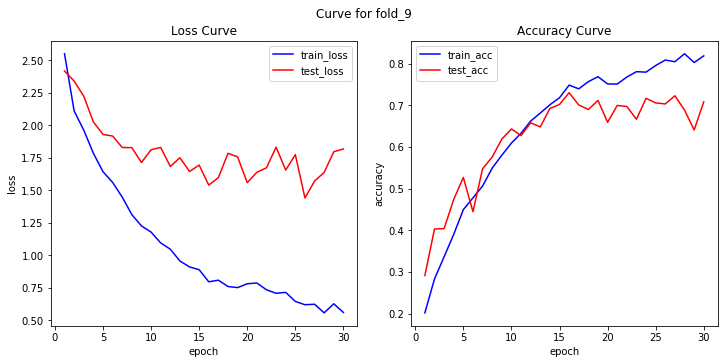

In [3]:
import matplotlib.pyplot as plt

SOURCE = '../log/train.log'
FOLD = 9

def extract_values(path):
    log_file = open(path, 'r')
    train = {}
    test = {}

    curr_train_loss = []
    curr_train_acc = []
    curr_test_loss = []
    curr_test_acc = []
    for line in log_file:
        items = line.strip().split()
        if len(items) == 17 and items[-2] == 'val_acc:':
            curr_train_loss.append(float(items[7]))
            curr_train_acc.append(float(items[10]))
            curr_test_loss.append(float(items[13]))
            curr_test_acc.append(float(items[16]))
        elif len(items) == 4 and items[0] == 'Cross':
            key = 'fold_' + items[-1]
            train[key + '_loss'] = curr_train_loss
            train[key + '_acc'] = curr_train_acc
            test[key + '_loss'] = curr_test_loss
            test[key + '_acc'] = curr_test_acc
            curr_train_loss = []
            curr_train_acc = []
            curr_test_loss = []
            curr_test_acc = []

    log_file.close()
    return train, test

def main():
    train, test = extract_values(SOURCE)
    key = 'fold_' + str(FOLD)
    train_loss = train[key + '_loss']
    train_acc = train[key + '_acc']
    test_loss = test[key + '_loss']
    test_acc = test[key + '_acc']
    epoch = [elem for elem in range(1, len(train_loss) + 1)]

    fig, axs = plt.subplots(1, 2, figsize = (10, 5), constrained_layout = True)
    fig.suptitle('Curve for ' + key)

    axs[0].plot(epoch, train_loss, c = 'blue', label = 'train_loss')
    axs[0].plot(epoch, test_loss, c = 'red', label = 'test_loss')
    axs[0].set_title('Loss Curve')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()

    axs[1].plot(epoch, train_acc, c = 'blue', label = 'train_acc')
    axs[1].plot(epoch, test_acc, c = 'red', label = 'test_acc')
    axs[1].set_title('Accuracy Curve')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend()

    plt.show()

if __name__ == '__main__':
    main()


The prediction procedure:

In [0]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import load_model
import librosa
from tqdm import tnrange, tqdm
import numpy as np

AUDIO_SOURCE = '../raw/audio/'
FOLD = 'fold1/'
AUDIO = '101415-3-0-2.wav'

mapping = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

def load_audio(path):
    y1, sr1 = librosa.load(path, duration = 2.97)
    ps = librosa.feature.melspectrogram(y = y1, sr = sr1)

    padding = 0
    if ps.shape != (128, 128):
        padding = 1
        diff = 128 - ps.shape[1]
        pattern = [0.0] * 128
        paddings = []
        for i in range(diff):
            paddings.append(pattern)
        paddings = np.array(paddings)
        ps = np.concatenate((ps, paddings.T), axis = 1)

    return ps

def main():
    source = AUDIO_SOURCE + FOLD + AUDIO

    gt = int(AUDIO.split('-')[1])
    data = load_audio(source)

    model = load_model('../models/Sample_CNN_Epoch_30_Fold_1.h5')

    data = data.reshape((1, 128, 128, 1))

    predict_vec = model.predict(data)
    label = ''
    max_prob = -1
    for i in range(predict_vec.shape[1]):
        if predict_vec[0, i] > max_prob:
            label = mapping[i]
            max_prob = predict_vec[0, i]

    print('\nPrediction for', source)
    print('The label is:', mapping[gt])
    print('The prediction is:', label)

if __name__ == '__main__':
    main()



Prediction for ../raw/audio/fold1/101415-3-0-2.wav
The label is: dog_bark
The prediction is: dog_bark
